# <CENTER> PURE :
# Notebook 1 - Data Extraction and Preparation for Recommendation Algorithm
This notebook focuses on retrieving data and tables from Google Cloud Platform (GCP) for building a product recommendation algorithm.

Two primary tables are utilized:
* `emea-c1-dwh-prd.emea_lld_local.JF_ORDERS_FOR_MATRIX`: Contains the historical purchase data of all YSL customers.
* `emea-c1-dwh-prd.emea_lld_local.JF_EAN_FOR_MATRIX_3d`: Lists products sold within the last three days, serving as a reference for the product catalog used in the recommendation algorithm.

This notebook, the first in a series of five, covers data retrieval and preparation. Several tables are constructed and saved locally as CSV files to be used in subsequent notebooks for computing the recommendation algorithm.


**Package importation**

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import bigframes.pandas as bpd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
import datetime
import re
from google.cloud import bigquery
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
import datetime
import random
import re
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

## Preprocessing df
This section likely details the steps involved in cleaning, transforming, and preparing the customer purchase history data for use in the recommendation algorithm.

Further details about the specific preprocessing steps would be needed for a more comprehensive summary.

**Data importation** :

Two primary tables are imported for analysis:

*  `df ` : This table likely contains detailed information about customer orders, such as order date, customer ID, products purchased, quantities, and potentially additional transactional details.

*  `last_eancode ` : This table seems to focus on product EAN codes (European Article Numbers, a type of barcode). It might contain a list of EAN codes representing products that were recently sold or are considered relevant for the recommendation engine.

These two tables provide the foundational data for constructing the personalized recommendation system.


**Importing Data Using Big Frames Library (Data Stored Locally on GCP)**

* Big Frames: This likely refers to a library or framework designed for working with large datasets. It might be a specific tool within the Google Cloud Platform (GCP) ecosystem.
* GCP (Google Cloud Platform): This is Google's suite of cloud computing services. Locally on GCP: This means the data is stored on a GCP service, but likely in a way that's directly accessible to the code being executed.

The specific Big Frames library and the exact nature of "locally on GCP" would necessitate more context or code snippets for precise identification.

In [ ]:
country = "FR"

In [ ]:
def import_data(country : "FR") :

  # Set BigQuery DataFrames options
  bpd.options.bigquery.project = "emea-c1-dwh-prd"

  # Initialise le client BigQuery
  client = bigquery.Client(project = "emea-c1-dwh-prd")

  # Create a DataFrame from a BigQuery table
  query_or_table = "SELECT * FROM  `emea-c1-dwh-prd.emea_lld_local.JF_ORDERS_FOR_MATRIX`"
  df = bpd.read_gbq(query_or_table)
  # filtered on the country
  df = df[df['country'] == country]

  index_col = 'index'
  df.index_name=index_col
  df=df.to_pandas()

  query_or_table = "SELECT * FROM `emea-c1-dwh-prd.emea_lld_local.JF_EAN_FOR_MATRIX_3d`"
  last_eancode = bpd.read_gbq(query_or_table)
  # filtered on the country
  last_eancode = last_eancode[last_eancode['country'] == country]

  index_col = 'index'
  last_eancode.index_name=index_col
  last_eancode=last_eancode.to_pandas()
  last_eancode.dropna(inplace=True)

  return df, last_eancode

**Database preprocessing** : df

This code focuses on preparing the customer database (df) for a recommendation system. It applies a series of filtering and transformation steps to retain only relevant and usable data.

The code outputs the total number of unique customers remaining in the database after preprocessing. This cleaned and transformed data is now ready for use in building the recommendation system.

In [ ]:
def df_preprocessing(df):
  df = df.dropna(subset=['ocdMasterId', 'marketing_product_label', 'eanCode'])

  #Returns to exclude :
  df['Transaction_Status'] = np.where(df['lineAmountTaxIncludedAfterDiscount_euro'] < 0, 'Return', 'Completed')
  df = df[df['Transaction_Status'] == 'Completed']

  #only orders with items price between 2 and 1 000 euros + calculus of sell_out total
  df = df[df['ItemPrice_EUR']>2]
  df = df[df['ItemPrice_EUR'] <= 1000]
  df['ticketOrOrderDate'] = df['ticketOrOrderDate'].dt.date

  df['gender'] = df['gender'].replace(['O', 'U'], 'Other')

  # age filtering
  df['age'] = df['age'].where(df['age'].between(16, 100), np.nan)
  df['ticketOrOrderDate'] = pd.to_datetime(df['ticketOrOrderDate'])

  print(f"Number of customers in the database (ocdMasterId) : {df['ocdMasterId'].nunique()}")
  print(f"Number of customers in the database (emailAdress) : {df['emailAddress'].nunique()}")
  print(f"Number of contactable in the database : {df[df['isContactableEmail'] == True]['ocdMasterId'].nunique()}")

  return df

In [ ]:
def initialisation_preprocessing() :
  data, last_eancode = import_data(country)
  df = df_preprocessing(data)
  return df, last_eancode

In [ ]:
df, last_eancode = initialisation_preprocessing()

Number of customers in the database (ocdMasterId) : 149987
Number of customers in the database (emailAdress) : 149262
Number of contactable in the database : 87914


In [ ]:
nb_contactables = df[df['isContactableEmail'] == True]['ocdMasterId'].nunique()

## Selecting Products for Discovery Recommendations from the "last_eancode" Table
This part of the analysis focuses on creating a curated subset of products from the "last_eancode" table specifically for use in "discovery" recommendations.

Instead of recommending products based solely on past user behavior, discovery recommendations aim to introduce users to new and potentially interesting items.

### Product Selection Criteria and Business Rules
The product selection process follows distinct rules established in collaboration with business stakeholders, ensuring the subset aligns with market insights and strategic goals. Here's a breakdown:

**Starting Point**: The analysis begins with a set of 251 products from the "last_eancode" table.

* **Fragrances**: For fragrances, the selection prioritizes diversity within product lines. Only one EAN code is retained for each unique combination of:

    * Franchise
    * Sub-franchise
    * Category (Métier)
    * Sub-category (Sous métier)
    * Marketing product label

*Selection Criterion*: Among products matching the criteria above, the one with the smallest available size ("contenance") is chosen.

* **Makeup**: Similar to fragrances, makeup product selection uses the same combination of franchise, sub-franchise, category, sub-category, and marketing product label. However, the key differentiator is:

*Selection Criterion*: For each unique combination, the product with the highest sales volume, representing the most popular shade, is chosen.

* **Skincare**: Skincare selection also considers combinations of franchise, sub-franchise, category, sub-category, and marketing product label.

*Selection Criterion*: Only one product is kept for each unique combination.


### Purpose of the Sub-catalog
This meticulously curated subset of products will form the basis for "discovery recommendations." By strategically choosing a diverse and representative sample of products, the recommendation system aims to introduce users to new items they are likely to find interesting but may not have discovered on their own. This approach can enhance user experience, promote product exploration, and potentially drive sales in new areas.

**MAKEUP/SKINCARE**

In [ ]:
def find_best_seller(df, eanCode_sold_in_3_days, axe):
  """
  Identify the best seller in the axis based on the sales within the last 3 months and filtered on the eanCodes sold in the last 3 days
  """

  today_date = pd.to_datetime('today')

  # Filtered on sales within the last 3 months
  three_months_old = today_date - pd.DateOffset(months=3)
  last_months_sales = df[(df['ticketOrOrderDate'] > three_months_old) & (df['axe'] == axe)]

  # Count the number of ticket with the product
  ean_counts = last_months_sales.groupby(['eanCode', 'axe', 'sub_axe', 'franchise', 'sous_franchise', 'productName', 'marketing_product_label'])['ocdTicketOrOrderId'].count().reset_index(name='sales_count')
  result_df = ean_counts.sort_values(by='sales_count', ascending=False)
  sales_count_series = result_df.set_index('eanCode')['sales_count']

  eanCode_sold_in_3_days['sales_count'] = eanCode_sold_in_3_days['eanCode'].map(sales_count_series).fillna(0).astype(int)

  eanCode_sold_in_3_days_filtered_axe = eanCode_sold_in_3_days[(last_eancode['axe'] == axe) & (last_eancode['refill']== "Regular")]
  colonnes_clés = ['axe', 'sub_axe', 'franchise', 'sous_franchise']
  #ean code with the highest sales count
  idx = eanCode_sold_in_3_days_filtered_axe.groupby(colonnes_clés)['sales_count'].idxmax()
  df_top = eanCode_sold_in_3_days_filtered_axe.loc[idx].reset_index(drop=True)

  return df_top

**FRAGRANCE**

In [ ]:
def extract_largest_ml(product_name):
    """Extracts the largest milliliter value from a product name string."""
    matches = re.findall(r'(\d+)ML', product_name)
    if matches:
        try:
            return max(int(match) for match in matches)
        except ValueError:
            return None
    return None

In [ ]:
def find_smallest_fragrance(df):
    """
    Identify by sub-franchise the perfume with the smallest available size (contenance)
    Args:
        df (pd.DataFrame): dataframe of product sold in the last 3 days

    Returns:
        df_frag_small (pd.DataFrame): DataFrame filtré avec les produits "Fragrance"
                      de plus petite contenance par sous-franchise + filtrer on non "hair" product coffret.
    """
    df_fragrance = df[df['axe'] == 'Fragrance']
    # delete the space
    df_fragrance['productName_without_space'] = df_fragrance['productName'].str.upper().str.replace(' ', '')

    # delete product for hair
    df_fragrance = df_fragrance[~df_fragrance['productName_without_space'].str.contains("HAIR", case=False)]

    # Extraire la contenance en ML
    df_fragrance['contenance_ml'] = df_fragrance['productName_without_space'].apply(extract_largest_ml)

    #df_fragrance['contenance_ml'] = df_fragrance['productName'].apply(lambda x: int(re.findall(r'(\d+)ML', x)[0]) if re.findall(r'(\d+)ML', x) else None)
    df_fragrance['contenance_ml'] = df_fragrance['contenance_ml'].fillna(float('inf'))

    df_fragrance = df_fragrance.sort_values('contenance_ml').drop_duplicates(subset=['productName'], keep='first')

    idx=df_fragrance.groupby('sous_franchise')['contenance_ml'].idxmin()
    df_frag_small=df_fragrance.loc[idx, ['eanCode', 'axe', 'sub_axe', 'franchise', 'sous_franchise', 'productName', 'contenance_ml', 'urlPage', 'imageMedium', 'marketing_product_label', 'metier', 'sub_metier','ItemPriceAvg']]
    return df_frag_small

After applying these business rules and selection criteria, our curated product catalog for discovery recommendations contains **76 unique products**. This carefully chosen subset balances diversity across product categories, franchises, and key attributes, while aligning with sales performance and strategic goals."

In [ ]:
def initialisation_products_for_discovery(df, last_eancode):

  df_makeup_top = find_best_seller(df, last_eancode, "MakeUp")
  df_fragrance = find_smallest_fragrance(last_eancode)
  df_skincare_top = find_best_seller(df, last_eancode, "Skin Care")

  products_recommandes = pd.concat([df_skincare_top, df_fragrance, df_makeup_top], ignore_index=True)
  products_recommandes = products_recommandes[['eanCode', 'productName', 'axe', 'sub_axe', 'franchise',
       'sous_franchise', 'marketing_product_label', 'metier', 'sub_metier',
       'ItemPriceAvg', 'sales_count', 'urlPage', 'imageMedium']]

  products_recommandes.to_csv(f"products_recommandes_{country}.csv")
  last_eancode.to_csv(f"last_eancode_{country}.csv")

  print("Number of products in the catalog :")
  print(products_recommandes['eanCode'].nunique())
  print("FRAGRANCE")
  print(products_recommandes[products_recommandes['axe'] == "Fragrance"]['productName'].unique())
  print("SKIN CARE")
  print(products_recommandes[products_recommandes['axe'] == "Skin Care"]['productName'].unique())
  print("MAKEUP")
  print(products_recommandes[products_recommandes['axe'] == "MakeUp"]['productName'].unique())
  return products_recommandes

In [ ]:
products_recommandes= initialisation_products_for_discovery(df, last_eancode)

Number of products in the catalog :
65
FRAGRANCE
<ArrowStringArray>
[                   'BO EDP 30ML /REG',        'YSL BO EDP RED V30ML FG PACK',
         'YSL BO GLITTER V30ML FG FIL',           'YSL BO LE PARFUM V30ML FG',
 'YSL JAZZ EDT VAPO80ML COLLEC YSL/NF',             'KRS EDT VAPO 100ML   NF',
        'HOM COLOGNE BLEUE EDT V100ML',  'YSL - LHOMME EDP RENO INTENSE 60ML',
                  'HOM EDT V60ML NF/2',   'YSL HOM LE PARFUM EDP V100ML PACK',
        'NUIT LE PARFUM VAPO 60ML /NF',       'YSL LNDH EDT 60ML + 10ML VD25',
              'YSL LVDP CUIR V75ML FG',         'LVDP JUMPSUIT S75ML FG /MAD',
      'LVPCO SPLENDID WOOD EDP V125ML',       'YSL LIBRE ABSOLU PLATINE 50ML',
              'LIBRE EDP S30ML FG/RFL',       'YSL LIBRE EDP FLORALE 30ML MV',
             'LIBRE EDT S50ML FG PACK',    'YSL LIBRE EDP INTENSE S30ML PACK',
           'YSL LIBRE LE PARFUM S30ML',      'M7 EDT VAPO 80ML COLLEC YSL/NF',
                     'YSL MYSLF V40ML',       'YSL MYSLF LE PAR

<ipython-input-12-f672dcc79207>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fragrance['productName_without_space'] = df_fragrance['productName'].str.upper().str.replace(' ', '')


## Transforming Transactional Data into Customer-Level Insights
This code segment transforms the initial transactional dataset (``df``) into a customer-centric dataset (``customer_data``), providing a comprehensive view of each customer's purchase history and characteristics.

The resulting ``customer_data`` dataframe provides a comprehensive view of each customer, including their purchase behavior, demographics, and engagement patterns. This enriched dataset is now primed for analysis or use in building a recommendation system.

In [ ]:
def database_to_clustering(df):
   # Calculate last purchase date, number of orders, number of products, and total sell-out per customers
  customer_data = df.groupby('ocdMasterId').agg(
        last_purchase_date=('ticketOrOrderDate', 'max'),
        first_purchase_date=('ticketOrOrderDate', 'min'),
        frequency=('ocdTicketOrOrderId', 'nunique'),
        nb_products=('itemQuantity', 'sum'),
        nb_distincts_products=('eanCode', 'nunique'),
        sell_out_total=('lineAmountTaxIncludedAfterDiscount_euro', 'sum'),
  ).reset_index()

  customer_data = pd.merge(customer_data, df[['ocdMasterId', 'age', 'gender', 'isContactableEmail', 'emailAddress']].drop_duplicates(), on='ocdMasterId', how='left')

  customer_data['AOV'] = customer_data['sell_out_total'] / customer_data['frequency']

  #sell out and frequency
  average_sell_out = customer_data['sell_out_total'].mean()
  average_frequency = customer_data['frequency'].mean()

  #euclidien distance for global shoppers
  customer_data['distance_to_average'] =  np.sqrt(
    (customer_data['sell_out_total'] - average_sell_out)**2 + (customer_data['frequency'] - average_frequency)**2)

  threshold = customer_data['distance_to_average'].quantile(0.995)

  #global shoppers exclusion
  global_shoppers = customer_data[customer_data['distance_to_average'] > threshold]['ocdMasterId']
  customer_data = customer_data[~customer_data['ocdMasterId'].isin(global_shoppers)]

  customer_data['last_purchase_date'] = pd.to_datetime(customer_data['last_purchase_date'])
  customer_data['first_purchase_date'] = pd.to_datetime(customer_data['first_purchase_date'])

  most_recent_date = pd.to_datetime(customer_data['last_purchase_date'].max())

  # Calculate Days Since Last Purchase
  customer_data['days_since_last_purchase'] = (most_recent_date - customer_data['last_purchase_date']).dt.days
  customer_data['month_purchase'] = customer_data['last_purchase_date'].dt.strftime('%B')
  customer_data = customer_data.drop('last_purchase_date', axis=1)

  # Calculate Days Since first Purchase
  customer_data['days_since_first_purchase'] = (most_recent_date - customer_data['first_purchase_date']).dt.days
  customer_data = customer_data.drop('first_purchase_date', axis=1)

  # Age categorization
  bins = [16, 25, 35, 45, 55, 65, 100]
  labels = ['16-25', '26-35', '36-45', '46-55', '56-65', '66+']
  customer_data['Age_Group'] = pd.cut(customer_data['age'], bins=bins, labels=labels, right=False)
  customer_data['Age_Group'] = customer_data['Age_Group'].cat.add_categories('No Age')
  customer_data['Age_Group'].fillna('No Age', inplace=True)

  age_group_encoded = pd.get_dummies(customer_data['Age_Group'], prefix='Age_Group', dtype = "int")
  customer_data = pd.concat([customer_data, age_group_encoded], axis=1)
  customer_data = customer_data.drop('Age_Group', axis=1)

  # Gender One-Hot Encoding

  customer_data['gender'].fillna('No Gender', inplace=True)
  genre_encoded = pd.get_dummies(customer_data['gender'], prefix='Gender', dummy_na=True, dtype = "int")
  customer_data = pd.concat([customer_data, genre_encoded], axis=1)
  ##customer_data = customer_data.drop('gender', axis=1)

  #if age is completed then age_cat = 1 (same thing for gender)
  customer_data['age_cat'] = customer_data['age'].notna().astype(int)
  customer_data['gender_cat'] = customer_data['gender'].isin(['F', 'M']).astype(int)

  return customer_data

In [ ]:
customer_data = database_to_clustering(df)

<ipython-input-15-45b2ea4ffd02>:49: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_data['Age_Group'].fillna('No Age', inplace=True)
<ipython-input-15-45b2ea4ffd02>:57: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

## Exportation CSV of the new dataframes created

In [ ]:
customer_data.to_csv(f"customer_data_{country}.csv", index=False)
df.to_csv(f"df_{country}.csv", index=False)

# CLUSTERING CLIENT


This notebook marks the second stage in building our product recommendation system. Here, our focus shifts to customer segmentation, aiming to group customers with similar purchasing behaviors. By understanding these distinct customer segments, we can develop a more tailored approach to recommending new products. This approach leverages the principle of collaborative filtering, suggesting products that customers within the same segment have purchased or interacted with. Importantly, this segmentation relies solely on customer purchase patterns and behaviors, not on the specific products they have bought. The insights derived from this analysis will play a crucial role in shaping our recommendation strategy.

The goal of this notebook is to create two distinct clusterings: one for the first method and one for the second. The first clustering will be coarse-grained, resulting in clusters containing a large number of customers. The second clustering should be as fine-grained as possible to achieve a more precise segmentation of customers, grouping them into highly homogeneous

Importation des **packages**

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mcolors
from scipy.stats import linregress
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
from tabulate import tabulate
from collections import Counter
import datetime
import random
import re

## Data Recuperation

Here we collect the tables created with the first Jupiter notebook. The tables are stored in our local session, we need to modify the path that allows access to the tables

In [ ]:
filepath = f"products_recommandes_{country}.csv"
products_recommandes = pd.read_csv(filepath)

filepath = f"last_eancode_{country}.csv"
last_eancode = pd.read_csv(filepath)

In [ ]:
customer_data=pd.read_csv(f"customer_data_{country}.csv")
df=pd.read_csv(f"df_{country}.csv")

# Customer clustering

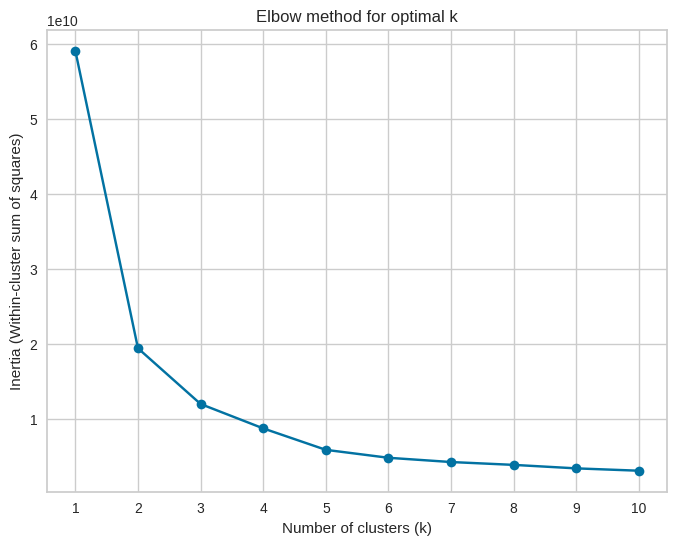

In [ ]:
#feature choice:
numerical_cols = ['frequency', 'nb_products', 'nb_distincts_products', 'sell_out_total', 'days_since_last_purchase','days_since_first_purchase','Age_Group_16-25', 'Age_Group_26-35', 'Age_Group_36-45','Age_Group_46-55', 'Age_Group_56-65', 'Age_Group_66+', 'Age_Group_No Age','Gender_F', 'Gender_M', 'Gender_Other']
data_scaled = customer_data.copy()

#standardization features
scaler = StandardScaler()
data_scaled[numerical_cols] = scaler.fit_transform(data_scaled[numerical_cols])

#k-means 1
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customer_data[numerical_cols])
    inertia.append(kmeans.inertia_)

#Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-cluster sum of squares)')
plt.title('Elbow method for optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [ ]:
def clustering(data, k):
  #feature choice:
  numerical_cols = ['frequency', 'nb_products', 'nb_distincts_products', 'sell_out_total', 'days_since_last_purchase','days_since_first_purchase','Age_Group_16-25', 'Age_Group_26-35', 'Age_Group_36-45','Age_Group_46-55', 'Age_Group_56-65', 'Age_Group_66+', 'Age_Group_No Age','Gender_F', 'Gender_M', 'Gender_Other']
  data_scaled = data.copy()

  #standardization features
  scaler = StandardScaler()
  data_scaled[numerical_cols] = scaler.fit_transform(data_scaled[numerical_cols])

  # K-Means on standardized data
  kmeans_1 = KMeans(n_clusters=k, random_state=42)
  kmeans_1.fit(data_scaled[numerical_cols])
  data['cluster'] = kmeans_1.labels_

  return data

In [ ]:
customer_data = clustering(customer_data, 5)

In [ ]:
#stat description per cluster
cluster_means = customer_data.groupby('cluster')[numerical_cols].mean().round(2)
cluster_means['customers']=customer_data['cluster'].value_counts()
cluster_means = cluster_means.reset_index()

In [ ]:
cluster_means

,cluster,frequency,nb_products,nb_distincts_products,sell_out_total,days_since_last_purchase,days_since_first_purchase,Age_Group_16-25,Age_Group_26-35,Age_Group_36-45,Age_Group_46-55,Age_Group_56-65,Age_Group_66+,Age_Group_No Age,Gender_F,Gender_M,Gender_Other,customers
0,0,1.25,1.96,1.78,100.92,1066.16,1136.84,0.04,0.16,0.09,0.09,0.05,0.04,0.54,0.00,0.00,1.00,24661
1,1,1.07,1.57,1.48,100.05,244.59,263.56,0.02,0.04,0.00,0.02,0.01,0.00,0.90,0.01,0.01,0.98,20091
2,2,4.11,9.23,7.16,455.93,443.80,1031.74,0.04,0.22,0.23,0.23,0.15,0.09,0.05,0.69,0.06,0.25,8929
3,3,1.23,1.99,1.83,119.24,618.82,685.13,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.77,0.16,0.07,24012
4,4,1.18,1.80,1.68,111.40,624.84,676.26,0.20,0.42,0.00,0.21,0.11,0.06,0.00,0.82,0.18,0.00,71544


In [ ]:
customer_data.to_csv(f"customer_data_{country}.csv")

df = pd.merge(customer_data[['ocdMasterId', 'cluster']], df, on = 'ocdMasterId', how='left')
df_achats = pd.merge(customer_data[['ocdMasterId', 'cluster']], df[['ocdMasterId', 'franchise', 'itemQuantity']], on = 'ocdMasterId', how='left')
df.to_csv(f"df_{country}.csv")
df_achats.to_csv("prep_user_item.csv")

# GENERATION OF THE TEST AND CONTROL GROUP

In [ ]:
def generation_test_control_group(df, last_eancode):
  # Filtered on contactable email customers
  df_contactables = df[df['isContactableEmail'] == True]

  ###### EXCLUSION OF CUSTOMERS WHO BOUGHT ONLY FRANCHISE WHICH DOES NOT EXIST ANYMORE -> IMPOSSIBLE TO FIND LOGICAL RECOMMANDATIONS

  # Bouléen si la franchise est présente dans le fichier last_eanCode (franchise encore vendues)
  df_contactables['franchise_presente'] = df_contactables['franchise'].isin(last_eancode['franchise']).astype(int)

  df_contactables['nb_achats'] = df_contactables.groupby('ocdMasterId')['ocdTicketOrOrderId'].transform('nunique')
  df_contactables['nb_franchise'] = df_contactables.groupby('ocdMasterId')['franchise'].transform('nunique')
  df_contactables['sum_franchise_presente'] = df_contactables.groupby('ocdMasterId')['franchise_presente'].transform('sum')

  customer_to_exclude = df_contactables[df_contactables['sum_franchise_presente']==0]


  # Select the desired columns
  customer_to_exclude = customer_to_exclude[['ocdMasterId', 'emailAddress', 'cluster']]

  # Drop duplicates to get unique rows
  customer_to_exclude = customer_to_exclude.drop_duplicates()

  print(len(customer_to_exclude))

  # Select the desired columns
  clients_eligible = df_contactables[['ocdMasterId', 'emailAddress', 'cluster']]

  # Drop duplicates to get unique rows
  clients_eligible = clients_eligible.drop_duplicates()

  clients_eligible = clients_eligible[~clients_eligible['ocdMasterId'].isin(customer_to_exclude['ocdMasterId'])].drop_duplicates(subset=['ocdMasterId'])

  clients_eligible['ocdMasterId'].nunique()
  size_test_group = (len(clients_eligible)+len(customer_to_exclude))//2
  control_group , test_group= train_test_split(clients_eligible, test_size=size_test_group, random_state=42, stratify=clients_eligible['cluster'])
  control_group = pd.concat([control_group, customer_to_exclude], ignore_index=True)

  print("Size of test group : ")
  print(len(test_group))
  print("Size of control group : ")
  print(len(control_group))

  print("Test si doublons on ocdMasterId: True if no doublons / False if doublons")
  print(pd.merge(control_group, test_group, on='ocdMasterId', how='inner').empty)

  print("Test si doublons on emailAddress: True if no doublons / False if doublons")
  print(pd.merge(control_group, test_group, on='emailAddress', how='inner').empty)

  test_group['GROUP'] = 'TEST'
  control_group['GROUP'] = 'CONTROL'

  # Save the results in csv:
  test_group.to_csv(f"{country}_PURE_TEST_GROUP.csv", index=False)
  control_group[['emailAddress']].to_csv(f"{country}_PURE_CONTROL_GROUP.csv", index=False)

  return test_group, control_group

# LOGICAL RECOMMENDATION

In [ ]:
def get_recommanded_product(last_eancode, recommended_franchise, products_already_purchased, products_recommanded, refill_to_push):
    """Recommends a product based on a prioritized logic."""

    products_already_purchased_in_franchise = products_already_purchased[products_already_purchased["franchise"] == recommended_franchise]
    products_recommanded_in_franchise = products_recommanded[products_recommanded["franchise"] == recommended_franchise]
    last_eancode_in_franchise = last_eancode[(last_eancode["franchise"] == recommended_franchise)]

    # Sub franchise not in franchises already recommended or purchased
    sous_franchises_a_recommander = list(set(last_eancode_in_franchise['sous_franchise'].tolist()) - set(products_recommanded_in_franchise["sous_franchise"].tolist()) - set(products_already_purchased_in_franchise["sous_franchise"].tolist()) )

    ## PRIO 1 - If in the franchise selected a refill exist we push the refill :
    refill_to_push = refill_to_push[refill_to_push["franchise"] == recommended_franchise]
    if not refill_to_push.empty:
        return refill_to_push.sample(1)

    ## PRIO 2 : if sub franchises not already purchased within the franchise
    elif sous_franchises_a_recommander:
        sous_franchise_recommandee = random.choice(sous_franchises_a_recommander)

        produits_disponibles = last_eancode_in_franchise[(last_eancode_in_franchise['sous_franchise'] == sous_franchise_recommandee) & (~last_eancode_in_franchise['marketing_product_label'].isin(products_recommanded["marketing_product_label"]))]

        if not produits_disponibles.empty:
            return produits_disponibles.sample(1)
        else :
          print("No product available")

    # If no other sub-franchise : we recommend a product not already purchased
    else:
      available_products = last_eancode_in_franchise[
              # In sub franchise already purchased
              (last_eancode_in_franchise['sous_franchise'].isin(products_already_purchased_in_franchise["sous_franchise"])) &
              # But not the same eanCode & Not the same marketing product label
              (~last_eancode_in_franchise['eanCode'].isin(products_already_purchased["eanCode"])) &
              (~last_eancode_in_franchise['marketing_product_label'].isin(products_already_purchased["marketing_product_label"])) &
              (~last_eancode_in_franchise['eanCode'].isin(products_recommanded["eanCode"])) &
              (~last_eancode_in_franchise['marketing_product_label'].isin(products_recommanded["marketing_product_label"]))
      ]

      if available_products.empty:
        available_products = last_eancode_in_franchise[
              # In sub franchise already purchased
              (last_eancode_in_franchise['sous_franchise'].isin(products_already_purchased["sous_franchise"])) &
              # But not the same eanCode & Not the same marketing product label
              (~last_eancode_in_franchise['eanCode'].isin(products_already_purchased["eanCode"])) &
              (~last_eancode_in_franchise['eanCode'].isin(products_recommanded["eanCode"])) &
              (~last_eancode_in_franchise['marketing_product_label'].isin(products_recommanded["marketing_product_label"]))
      ]

      if available_products.empty:
        available_products = last_eancode_in_franchise[
                      # In sub franchise already purchased
                      (last_eancode_in_franchise['sous_franchise'].isin(products_already_purchased["sous_franchise"])) &
                      # But not the same eanCode & Not the same marketing product label
                      (~last_eancode_in_franchise['eanCode'].isin(products_recommanded["eanCode"])) &
                      (~last_eancode_in_franchise['marketing_product_label'].isin(products_recommanded["marketing_product_label"]))
        ]

      if available_products.empty:
        return None
      else:
        return available_products.sample(1)
    return None


def recommandation_logique(df, customer_data, last_eancode, n_recommandations, max_iter, n_clients=None):
    """Generates product recommendations based on customer purchase history."""

    recommandations = []
    ids_to_force_in_control_group = []

    if n_clients is not None:
        clients_a_traiter = random.sample(list(customer_data['ocdMasterId'].unique()), n_clients)
    else:
        clients_a_traiter = customer_data['ocdMasterId'].unique()

    for customer_id in clients_a_traiter:
        # Filtered purchased on id client
        customer_purchases = df[df['ocdMasterId'] == customer_id][["axe","franchise","sous_franchise", "marketing_product_label", "eanCode"]].drop_duplicates()
        franchises_already_purchased = customer_purchases["franchise"].drop_duplicates()
        sub_franchises_already_purchased = customer_purchases["sous_franchise"].drop_duplicates()

        # Franchises already purchased and still available
        franchises_available = last_eancode[last_eancode['franchise'].isin(franchises_already_purchased)]['franchise'].unique().tolist()

        products_already_purchased = customer_purchases.drop_duplicates()
        products_recommanded = pd.DataFrame(columns=products_already_purchased.columns)


        nb_recommandations = 0

        # Refill available in sub franchise already purchased
        refill_to_push = last_eancode[
            (last_eancode['franchise'].isin(franchises_already_purchased)) &
            (last_eancode['sous_franchise'].isin(sub_franchises_already_purchased)) &
            (last_eancode['refill'] == "Refill")
        ].drop_duplicates(subset=['franchise', 'sous_franchise'], keep='first') # keep one refill by sub franchise

        i = 0

        while nb_recommandations < n_recommandations and i < max_iter:
            i += 1
            if franchises_available:
                # Random franchise
                franchise_recommandee = random.choice(franchises_available)


            elif products_recommanded["franchise"].any():
                franchise_recommandee = random.choice(products_recommanded["franchise"])
            else:
                break

            produit_recommande = get_recommanded_product(last_eancode, franchise_recommandee, products_already_purchased,products_recommanded, refill_to_push)

            if produit_recommande is not None :
              # On ajoute le produit dans le dataframe de produits recommandés
              products_recommanded = pd.concat([products_recommanded, pd.DataFrame(produit_recommande)], ignore_index=True)

              if franchise_recommandee in franchises_available:
                  franchises_available.remove(franchise_recommandee)

              refill_to_push = refill_to_push[refill_to_push['eanCode'] != produit_recommande['eanCode'].iloc[0]]
              nb_recommandations += 1


        if i == max_iter :
          id_to_force_in_control_group = {'ocdMasterId': customer_id}
          id_to_force_in_control_group['emailAddress'] = customer_data[customer_data['ocdMasterId'] == customer_id]['emailAddress'].iloc[0]
          ids_to_force_in_control_group.append(id_to_force_in_control_group)


        else :
          recommandation_data = {'ocdMasterId': customer_id}
          recommandation_data['emailAddress'] = customer_data[customer_data['ocdMasterId'] == customer_id]['emailAddress'].iloc[0]


          for i, reco in enumerate(products_recommanded['eanCode']): # Iterate over the EAN codes from each returned DF not the DF itself.
              recommandation_data[f'reco_logical_{i+1}_eanCode'] = reco
              produit_info = last_eancode[last_eancode['eanCode'] == reco].iloc[0] if not last_eancode[last_eancode['eanCode'] == reco].empty else None
              if produit_info is not None:
                produit_info = last_eancode[last_eancode['eanCode'] == reco].iloc[0]
                recommandation_data[f'reco_logical_{i+1}_productName'] = produit_info['marketing_product_label']
                recommandation_data[f'reco_logical_{i+1}_subFranchise'] = produit_info['sous_franchise']
                recommandation_data[f'reco_logical_{i+1}_franchise'] = produit_info['franchise']
                recommandation_data[f'reco_logical_{i+1}_refillOrNot'] = produit_info['refill']
                recommandation_data[f'reco_logical_{i+1}_urlPage'] = produit_info['urlPage']
                recommandation_data[f'reco_logical_{i+1}_imageMedium'] = produit_info['imageMedium']

          recommandations.append(recommandation_data)

    recommandations = pd.DataFrame(recommandations)
    ids_to_force_in_control_group = pd.DataFrame(ids_to_force_in_control_group)

    return recommandations, ids_to_force_in_control_group

# DISCOVERY RECOMMENDATION
Now we shift focus to implementing discovery recommendations, leveraging a pre-prepared product catalog.

Key principles for generating discovery recommendations include:

Diversity and Relevance : Offer three recommendations per customer, ensuring representation from at least two different product axes to encourage exploration of new categories.

Collaborative Filtering: Base recommendations on purchase history of customers within the same cluster, capitalizing on similar taste profiles.

New Franchise Discovery: Exclude franchises already purchased by the customer from recommendations, prioritizing the introduction to new brands and product lines.



## Similarité based on cosinus

In [ ]:
def aggregate_columns_by_mode(df, columns_to_aggregate, groupby_column='sous_franchise'):
    """
    Aggregates product information at sub franchise level

    Args:
        df (pd.DataFrame)
        columns_to_aggregate (list): A list of column names to aggregate.
        groupby_column (str)

    Returns:
        pd.DataFrame
    """

    aggregated_df = df.groupby(groupby_column)[columns_to_aggregate].agg(
        lambda x: x.mode()[0] if not x.empty else None
    ).reset_index()

    for col in columns_to_aggregate:
        aggregated_df[col] = aggregated_df[col].fillna("Unknown")

    return aggregated_df

In [ ]:
def calculate_sub_franchise_similarity(df, columns_for_similarity, hierarchy=None):
    """
    Calculates the similarity between sub_franchises

    Args:
        df (pd.DataFrame)
        columns_for_similarity (list): List of column names to use for similarity.
        hierarchy (dict): If not provided, all columns are weighted equally.

    Returns:
        pd.DataFrame: Similarity matrix between sub_franchises.
    """

    if hierarchy is None:
        hierarchy = {col: 1 for col in columns_for_similarity} # By default: equal weights

    sub_franchise_names = df['sous_franchise'].values

    # One-hot encoding
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    encoded_features = ohe.fit_transform(df[columns_for_similarity])


    # Apply weights from the hierarchy (if provided)
    feature_weights = {}
    for i, col in enumerate(ohe.get_feature_names_out(columns_for_similarity)):
        level = col.split('_', maxsplit=1)[0] # Extract original column name for matching with hierarchy
        feature_weights[i] = hierarchy.get(level, 1)  # Default weight of 1 if not in hierarchy
    weighted_features = encoded_features * np.array(list(feature_weights.values()))

    item_item_sparse = csr_matrix(weighted_features)  # Convert to a sparse matrix
    similarity_matrix = cosine_similarity(item_item_sparse, dense_output=False)  # Calculate cosine similarity
    return similarity_matrix,sub_franchise_names

## Recommendation at sub franchise level

In [ ]:
def recommend_sub_franchise_hybrid(user_id, user_item_matrix, sub_franchise_similarity, sub_franchises_names,  user_similarity, product_info, user_weight=0.5, item_weight=0.5):
    """Recommends sub_franchises using a hybrid approach (optimized for sparse matrices).

    Args:
        user_id: Id of the customer.
        user_item_matrix (pd.DataFrame): User-item interaction matrix.
        sub_franchise_similarity (csr_matrix or pd.DataFrame): Sub_franchise similarity matrix
        sub_franchises_names : List of sub_franchises names
        user_similarity:  User similarity matrix
        top_n (int, optional): Number of top recommendations to return. Defaults to 3.
        user_weight (float, optional): Weight for user-based similarity. Defaults to 0.5.
        item_weight (float, optional): Weight for item-based similarity. Defaults to 0.5.

    Returns:
        list: List of recommended sub_franchise names for the customer.  Returns None if no recommendations can be generated.
    """

    try:
        user_interactions = user_item_matrix.loc[user_id]
    except KeyError:
        print(f"User {user_id} not found in user-item matrix. Returning None.")
        return None

    interacted_sub_franchises = user_interactions[user_interactions > 0].index

    # Create mappings for sub_franchise and user IDs to numerical indices:
    sub_franchise_to_index = {sub_franchise: i for i, sub_franchise in enumerate(user_item_matrix.columns)}
    user_to_index = {user: i for i, user in enumerate(user_item_matrix.index)}

    interacted_sub_franchises_indices = [sub_franchise_to_index[sf] for sf in interacted_sub_franchises if sf in sub_franchise_to_index]

    # 1. Item-based similarity :
    if isinstance(sub_franchise_similarity, csr_matrix):
        if interacted_sub_franchises_indices:
            item_based_scores = sub_franchise_similarity[interacted_sub_franchises_indices, :].mean(axis=0).A1
            item_based_scores = pd.Series(item_based_scores, index=sub_franchises_names)
        else:
            item_based_scores = pd.Series(0, index=user_item_matrix.columns)
    else:
        item_based_scores = sub_franchise_similarity.loc[interacted_sub_franchises].T.dot(user_interactions[interacted_sub_franchises])


    # 2. User-based similarity :
    try:
        if isinstance(user_similarity, csr_matrix):
            user_index = user_to_index.get(user_id)
            if user_index is not None:
                similar_users_sparse = user_similarity[user_index]
                similar_users = pd.Series(similar_users_sparse.toarray().ravel(), index=user_item_matrix.index)
            else:
                similar_users = None
        else:
            similar_users = user_similarity.loc[user_id]

    except KeyError:
        print(f"User {user_id} not found in user similarity matrix. Using only item-based similarity.")
        similar_users = None

    if similar_users is not None:
        similar_users = similar_users[similar_users.index.isin(user_item_matrix.index)]
        similar_users = similar_users[user_item_matrix.loc[similar_users.index, interacted_sub_franchises].sum(axis=1) > 0]

        if similar_users.empty:
            print(f"No similar users who have interacted with the same sub_franchises as user {user_id}. Using only item-based similarity")
            similar_users = None


    if similar_users is not None:
        user_based_scores = user_item_matrix.loc[similar_users.index].T.dot(similar_users) / similar_users.sum()

        if not isinstance(item_based_scores, pd.Series):
          item_based_scores = pd.Series(item_based_scores, index=user_item_matrix.columns)


        combined_scores = (item_weight * item_based_scores.fillna(0)) + (user_weight * user_based_scores.fillna(0))
    else:
        combined_scores = item_based_scores

    combined_scores = combined_scores.drop(interacted_sub_franchises, errors='ignore').sort_values(ascending=False)

    recommendations_df = pd.DataFrame({'sous_franchise': combined_scores.index, 'score': combined_scores.values})
    recommendations_df = pd.merge(recommendations_df, product_info[["axe", "franchise", "sous_franchise"]], on='sous_franchise', how='left').drop_duplicates()
    recommendations_df['rank'] = recommendations_df['score'].rank(ascending=False, method='dense')

    return recommendations_df.sort_values('rank')

## Recommendation at product level

In [ ]:
def get_recommended_products(recommended_sub_franchises, product_recommande, products_already_purchased, top_n=2):

    # Select product according to recommendations
    recommended_products = pd.DataFrame()
    for i in range(len(recommended_sub_franchises)):
      sub_franchise = recommended_sub_franchises["sous_franchise"].iloc[i]
      franchise = recommended_sub_franchises["franchise"].iloc[i]

      if (products_already_purchased["franchise"].isin([franchise]).any()) or (products_already_purchased["sous_franchise"].isin([sub_franchise]).any()):
        pass
      else :
        # Recommendation based on the subfranchise
        product_to_recommend = product_recommande[(product_recommande['sous_franchise'] == sub_franchise) & (product_recommande['franchise'] == franchise)]
        if product_to_recommend.empty is False :
          recommended_products = pd.concat([recommended_products, product_to_recommend.sample(1)], ignore_index=True)
          products_already_purchased = pd.concat([products_already_purchased, product_to_recommend], ignore_index=True)

      if len(recommended_products) == top_n:
          return recommended_products

    return recommended_products

In [ ]:
def discovery_recommandations_by_cluster(test_group_cluster, user_item, cluster, similarity_matrix_item, sub_franchises_names, n_recommandations_discovery) :

  # Calculation of the similarity within the user in the same cluster
  user_item_sparse = csr_matrix(user_item)
  similarity_matrix_user = cosine_similarity(user_item_sparse, dense_output=False)

  discovery_recommandations = pd.DataFrame()

  for id in test_group_cluster['ocdMasterId']:
    recommendations = recommend_sub_franchise_hybrid(
        user_id=id,
        user_item_matrix=user_item,
        sub_franchise_similarity=similarity_matrix_item,
        sub_franchises_names =   sub_franchises_names,
        user_similarity=similarity_matrix_user,
        product_info=last_eancode
    )

    #print(id)
    #print("Top 5 Recommended Sub Franchises to discover: ")
    #print(recommendations)
    #print("Already purchased : ")
    #print(df[df['ocdMasterId'] == id]["sous_franchise"].unique())
    #print(df[df['ocdMasterId'] == id]["productName"].unique())
    #print("Recommended Product based on the rules: ")

    products_already_purchased = df[df['ocdMasterId'] == id][["franchise", "sous_franchise", "marketing_product_label"]].drop_duplicates()

    recommended_product = get_recommended_products(recommendations, products_recommandes, products_already_purchased, n_recommandations_discovery)

    new_data = {'ocdMasterId': id, 'cluster' : cluster}

    for i, reco in enumerate(recommended_product['eanCode']):
      new_data[f'reco_discovery_{i+1}_eanCode'] = reco
      produit_info = last_eancode[last_eancode['eanCode'] == reco].iloc[0] if not last_eancode[last_eancode['eanCode'] == reco].empty else None
      if produit_info is not None:
        produit_info = last_eancode[last_eancode['eanCode'] == reco].iloc[0]
        new_data[f'reco_discovery_{i+1}_productName'] = produit_info['marketing_product_label']
        new_data[f'reco_discovery_{i+1}_subFranchise'] = produit_info['sous_franchise']
        new_data[f'reco_discovery_{i+1}_franchise'] = produit_info['franchise']
        new_data[f'reco_discovery_{i+1}_refillOrNot'] = produit_info['refill']
        new_data[f'reco_discovery_{i+1}_urlPage'] = produit_info['urlPage']
        new_data[f'reco_discovery_{i+1}_imageMedium'] = produit_info['imageMedium']

    # Ajouter les nouvelles données au DataFrame.
    discovery_recommandations = pd.concat([discovery_recommandations, pd.DataFrame([new_data])], ignore_index=True)

  return discovery_recommandations

## Initialization of the discovery recommendation

In [ ]:
def initialisation_discovery(customer_data, df, last_eancode, products_recommandes, test_group, n_recommandations_discovery):
  total_discovery = pd.DataFrame()

  columns_to_agg = ['axe', 'sub_axe', 'metier', 'sub_metier', 'franchise']
  aggregated_df = aggregate_columns_by_mode(df, columns_to_agg)


  # Calculate similarity, optionally provide a hierarchy
  hierarchy = {'axe': 1, 'sub_axe': 2, 'metier': 1, 'sub_metier': 2, 'franchise': 0}

  similarity_matrix_item, sub_franchises_names = calculate_sub_franchise_similarity(aggregated_df, columns_to_agg, hierarchy)

  cluster_dataframes = {}

  for cluster_id in range(0, 6):
    cluster_data = customer_data[customer_data['cluster'] == cluster_id]
    df_achats = pd.merge(cluster_data, df[['ocdMasterId', 'sous_franchise','itemQuantity']], on='ocdMasterId', how='left')
    df_achats = df_achats[['ocdMasterId', 'sous_franchise', 'itemQuantity']]
    cluster_dataframes[f'cluster_{cluster_id}'] = df_achats

  user_item_matrices = {}

  for cluster_id in cluster_dataframes:
      cluster_data = cluster_dataframes[cluster_id]
      user_item_matrix = pd.pivot_table(cluster_data, values='itemQuantity', index='ocdMasterId', columns='sous_franchise', fill_value=0, aggfunc='sum')
      user_item_matrices[f'{cluster_id}_matrix'] = user_item_matrix


  for cluster_id in range(0, 5):
    user_item = user_item_matrices[f'cluster_{cluster_id}_matrix']
    test_group_cluster = test_group[test_group['cluster'] == cluster_id]
    total_discovery = pd.concat([total_discovery, discovery_recommandations_by_cluster(test_group_cluster, user_item, cluster_id, similarity_matrix_item, sub_franchises_names, n_recommandations_discovery)], ignore_index=True)

  return total_discovery

# FINAL FUNCTION

In [ ]:
def initialisation_recommandations(n_recommandations_logical=2, n_recommandations_discovery=2, max_iter=5) :
  customer_data = pd.read_csv(f"customer_data_{country}.csv")
  df = pd.read_csv(f"df_{country}.csv")
  last_eancode = pd.read_csv(f"last_eancode_{country}.csv")
  products_recommandes = pd.read_csv(f"products_recommandes_{country}.csv")

  # Clean the database : delete the column
  customer_data = customer_data.drop(customer_data.columns[0], axis=1)
  df = df.drop(df.columns[0], axis=1)
  last_eancode = last_eancode.drop(last_eancode.columns[0], axis=1)
  products_recommandes = products_recommandes.drop(products_recommandes.columns[0], axis=1)

  # Call the generation test and control group function
  test_group, control_group = generation_test_control_group(df, last_eancode)
  #test_group= test_group.sample(3000)

  # We begin with the logical recommandations
  recommandations_logical_test, ids_to_force_in_control_group = recommandation_logique(df, test_group, last_eancode,n_recommandations_logical, max_iter)

  # For those who is not posssible to find logical recommandations we push them in the control group
  if ids_to_force_in_control_group is not None:
    control_group = pd.concat([control_group, ids_to_force_in_control_group], ignore_index=True)
    test_group = test_group[~test_group['ocdMasterId'].isin(ids_to_force_in_control_group['ocdMasterId'])]
    print("Number of id to push in control group")
    print(len(ids_to_force_in_control_group))

  # Call of the discovery recommandation function
  recommandations_discovery_test = initialisation_discovery(customer_data, df, last_eancode, products_recommandes, test_group, n_recommandations_discovery)

  # Merge on the logical recommandations and discovery based on the ocdMasterId
  merged_recommandations = pd.merge(recommandations_logical_test, recommandations_discovery_test, on='ocdMasterId', how='outer')

  return merged_recommandations, control_group

In [ ]:
merged_recommandations,control_group = initialisation_recommandations()

<ipython-input-27-baa7d763e597>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contactables['franchise_presente'] = df_contactables['franchise'].isin(last_eancode['franchise']).astype(int)
<ipython-input-27-baa7d763e597>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_contactables['nb_achats'] = df_contactables.groupby('ocdMasterId')['ocdTicketOrOrderId'].transform('nunique')
<ipython-input-27-baa7d763e597>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

2961
Size of test group : 
43715
Size of control group : 
43716
Test si doublons on ocdMasterId: True if no doublons / False if doublons
True
Test si doublons on emailAddress: True if no doublons / False if doublons
False
Number of id to push in control group
736


# Tests

In [ ]:
merged_recommandations

,ocdMasterId,emailAddress,reco_logical_1_eanCode,reco_logical_1_productName,reco_logical_1_subFranchise,reco_logical_1_franchise,reco_logical_1_refillOrNot,reco_logical_1_urlPage,reco_logical_1_imageMedium,reco_logical_2_eanCode,...,reco_discovery_1_refillOrNot,reco_discovery_1_urlPage,reco_discovery_1_imageMedium,reco_discovery_2_eanCode,reco_discovery_2_productName,reco_discovery_2_subFranchise,reco_discovery_2_franchise,reco_discovery_2_refillOrNot,reco_discovery_2_urlPage,reco_discovery_2_imageMedium
0,m_00048b77-fd14-430b-b3f3-23aab44df962,kari67200@hotmail.fr,3614273776127,Libre Le Parfum,Libre Le Parfum,Libre,Regular,https://www.yslbeauty.fr/icones/nouveautes/lib...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614271640857,...,Regular,https://www.yslbeauty.fr/offres-et-cadeaux/off...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614273601092,Mascara Lash Clash,Mascara Lash Clash,Mascara Lash Clash,Regular,https://www.yslbeauty.fr/icones/best-sellers/m...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
1,m_00053d15-d17b-4361-af8a-b09ec276a2a8,rousselimmo@aol.com,3614272972636,Mascara VEFC Noir Radical,MVEFC Radical,Mascara Volume Effet Faux Cils,Regular,https://www.yslbeauty.fr/icones/best-sellers/m...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440225305,...,Regular,https://www.yslbeauty.fr/icones/best-sellers/l...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440787858,Black Opium EDP,Black Opium EDP,Black Opium,Regular,https://www.yslbeauty.fr/ysl-emea-west-navigat...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
2,m_00059de6-fdc5-4eef-8df4-20c839b22ff5,antoinette.bartoli@wanadoo.fr,3614273951081,Rouge Pur Couture,Rouge Pur Couture,Rouge Pur Couture,Refill,https://www.yslbeauty.fr/icones/nouveautes/rec...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614272972636,...,Regular,https://www.yslbeauty.fr/icones/best-sellers/l...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440787858,Black Opium EDP,Black Opium EDP,Black Opium,Regular,https://www.yslbeauty.fr/ysl-emea-west-navigat...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
3,m_0005b779-7c28-4daa-8573-0fd9c8d401f9,josso.mallory@wanadoo.fr,3614272972636,Mascara VEFC Noir Radical,MVEFC Radical,Mascara Volume Effet Faux Cils,Regular,https://www.yslbeauty.fr/icones/best-sellers/m...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440225305,...,Regular,https://www.yslbeauty.fr/icones/best-sellers/l...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440787858,Black Opium EDP,Black Opium EDP,Black Opium,Regular,https://www.yslbeauty.fr/ysl-emea-west-navigat...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
4,m_0005c365-7c54-42ed-af12-3bb0b3301994,christina-verso@hotmail.com,3614273984461,Pure Shots Night Reboot Serum,Pure Shots,Pure Shots,Refill,https://www.yslbeauty.fr/icones/nouveautes/rec...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614272354869,...,Regular,https://www.yslbeauty.fr/maquillage/maquillage...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614274284973,MVEFC Classic,MVEFC,Mascara Volume Effet Faux Cils,Regular,https://www.yslbeauty.fr/offres-et-cadeaux/off...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42974,m_fff907e6-e3e6-40fa-9c88-51a0fb866a96,bereaukarine@hotmail.fr,3614272972636,Mascara VEFC Noir Radical,MVEFC Radical,Mascara Volume Effet Faux Cils,Regular,https://www.yslbeauty.fr/icones/best-sellers/m...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3614274367805,...,Regular,https://www.yslbeauty.fr/ysl-emea-west-navigat...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...,3365440556300,Opium EDP,Opium EDP,Opium,Regular,https://www.yslbeauty.fr/offres-et-cadeaux/off...,https://www.yslbeauty.fr/dw/image/v2/AAQP_PRD/...
42975,m_fffdaac1-0b0a-42ec-8670-f45118f9a404,laprevotte_isabelle@hotmail.fr,3614274185317,Black Opium Glitter EDP,Black Opium Glitter EDP,Black Opium,Regular,https

In [ ]:
def tests_doublons_ocdMasterId(control_data, test_data) :
  doublons = pd.merge(control_data, test_data, on='ocdMasterId', how='inner')
  if len(doublons) == 0 :
    return True
  else :
    return len(doublons)

In [ ]:
def tests_doublons_emailAddress(control_data, test_data) :
  doublons = pd.merge(control_data, test_data, on='emailAddress', how='inner')
  if len(doublons) == 0 :
    return True
  else :
    return len(doublons)

In [ ]:
def clean_output(control_data, test_data):

  # Delete duplicate email in each file
  control_data = control_data.drop_duplicates(subset='emailAddress', keep='first')
  test_data =  test_data.drop_duplicates(subset='emailAddress', keep='first')

  # Delete duplicate email control/test to not send both control and test
  doublons_email = pd.merge(control_data, test_data, on='emailAddress', how='inner')["emailAddress"]
  control_group_without_doublons_email = control_data[~control_data['emailAddress'].isin(doublons_email)]
  print(pd.merge(test_data, control_group_without_doublons_email, on='emailAddress', how='inner').empty)

  # delete the beginning of the url
  for col in test_data.columns:
      test_data[col] = test_data[col].astype(str).str.replace('https://www.yslbeauty.fr', '', regex=False)
      test_data[col] = test_data[col].astype(str).str.replace('https://www.yslbeauty.co.uk', '', regex=False)

  print("Test no doublons ocdMasterId : ")
  print(tests_doublons_ocdMasterId(control_group_without_doublons_email, test_data))
  print("Test no doublons emailAddress : ")
  print(tests_doublons_emailAddress(control_group_without_doublons_email, test_data))
  print("Size of control group ")
  print(len(control_group_without_doublons_email))
  print("Size of test group ")
  print(len(test_data))

  return control_group_without_doublons_email, test_data

In [ ]:
control_group, test_group = clean_output(control_group, merged_recommandations)

True


<ipython-input-40-694fa54eb9dd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = test_data[col].astype(str).str.replace('https://www.yslbeauty.fr', '', regex=False)
<ipython-input-40-694fa54eb9dd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[col] = test_data[col].astype(str).str.replace('https://www.yslbeauty.co.uk', '', regex=False)
<ipython-input-40-694fa54eb9dd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

Test no doublons ocdMasterId : 
True
Test no doublons emailAddress : 
True
Size of control group 
44316
Size of test group 
42931


In [ ]:
def tests_output_different_product_name(control_data, test_data) :
  test_data['all_different_productName'] = test_data[['reco_logical_1_productName',
                                        'reco_logical_2_productName',
                                        'reco_discovery_1_productName',
                                        'reco_discovery_2_productName']].apply(
          lambda row: len(set(row)) == 4, axis=1
      )

  return test_data['all_different_productName'].value_counts().to_dict()

In [ ]:
tests_output_different_product_name(control_group, test_group)

<ipython-input-42-2c7de6a2e2b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['all_different_productName'] = test_data[['reco_logical_1_productName',


{True: 42931}

In [ ]:
def tests_output_different_sub_franchise_1(control_data, test_data) :
  test_data['all_different_subFranchise_log1'] = test_data[['reco_logical_1_subFranchise',
                                        'reco_discovery_1_subFranchise',
                                        'reco_discovery_2_subFranchise']].apply(
          lambda row: len(set(row)) == 3, axis=1
      )

  return test_data['all_different_subFranchise_log1'].value_counts().to_dict()

In [ ]:
tests_output_different_sub_franchise_1(control_group, test_group)

<ipython-input-44-faf1431339d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['all_different_subFranchise_log1'] = test_data[['reco_logical_1_subFranchise',


{True: 42931}

In [ ]:
def tests_output_different_sub_franchise_2(control_data, test_data) :
  test_data['all_different_subFranchise_log2'] = test_data[['reco_logical_2_subFranchise',
                                        'reco_discovery_1_subFranchise',
                                        'reco_discovery_2_subFranchise']].apply(
          lambda row: len(set(row)) == 3, axis=1
      )

  return test_data['all_different_subFranchise_log2'].value_counts().to_dict()

In [ ]:
tests_output_different_sub_franchise_2(control_group, test_group)

<ipython-input-46-48a54f1f630b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['all_different_subFranchise_log2'] = test_data[['reco_logical_2_subFranchise',


{True: 42931}

In [ ]:
control_group.to_csv(f"{country}_PURE_CONTROL_GROUP_RECOMMANDATION.csv", index=False)

In [ ]:
test_group.to_csv(f"{country}_PURE_TEST_GROUP_RECOMMANDATION.csv", index=False)

#AUTRE

In [ ]:
country = "GB"

In [ ]:
# check output

In [ ]:
#test_data = pd.read_csv(f"{country}_PURE_TEST_GROUP_RECOMMANDATION.csv")
control_data = pd.read_csv(f"{country}_PURE_CONTROL_GROUP.csv")

In [ ]:
test_data = pd.read_csv("UK_GROUP_TEST.csv", sep = ";")

In [ ]:
test_data["how_many_eanCode_different"] = test_data.apply(lambda row: len(set([row["reco_logical_1_eanCode"],
                                                                               row["reco_logical_2_eanCode"],
                                                                               row["reco_logical_3_eanCode"],
                                                                               row["reco_discovery_eanCode"]])) == 4, axis=1)

In [ ]:
test_data["how_many_eanCode_different"].value_counts()

,count
how_many_eanCode_different,
True,41349
False,1731


In [ ]:
len(test_data)

43080

In [ ]:
len(control_data)

43105

In [ ]:
pd.merge(control_data, test_data, on='emailAddress', how='outer')["emailAddress"].nunique()

86115

In [ ]:
def clean_output(control_data, test_data):

  # If discovery franchise equal to one of the logical franchise -> FORCED TO GROUP CONTROL
  test_data['is_discovery_different'] = (test_data['reco_discovery_franchise'] != test_data['reco_logical_1_franchise']) & (test_data['reco_discovery_franchise'] != test_data['reco_logical_2_franchise']) & (test_data['reco_discovery_franchise'] != test_data['reco_logical_3_franchise'])

  print(test_data['is_discovery_different'].value_counts())

  test_data["how_many_eanCode_different"] = test_data.apply(lambda row: len(set([row["reco_logical_1_eanCode"],
                                                                               row["reco_logical_2_eanCode"],
                                                                               row["reco_logical_3_eanCode"],
                                                                               row["reco_discovery_eanCode"]])) == 4, axis=1)
  print(test_data["how_many_eanCode_different"].value_counts())


  control_data = pd.concat([control_data, test_data.loc[test_data['is_discovery_different'] == False, ['emailAddress']]], ignore_index=True)
  test_data = test_data[test_data['is_discovery_different'] == True]

  control_data = pd.concat([control_data, test_data.loc[test_data['how_many_eanCode_different'] == False, ['emailAddress']]], ignore_index=True)
  test_data = test_data[test_data['how_many_eanCode_different'] == True]

  # Delete duplicate email in each file
  control_data = control_data.drop_duplicates(subset='emailAddress', keep='first')
  test_data =  test_data.drop_duplicates(subset='emailAddress', keep='first')

  # Delete duplicate email control/test to not send both control and test
  print(len(pd.merge(control_data, test_data, on='emailAddress', how='inner')))
  doublons_email = pd.merge(control_data, test_data, on='emailAddress', how='inner')["emailAddress"]
  test_group_without_doublons_email = test_data[~test_data['emailAddress'].isin(doublons_email[:round(len(doublons_email)/2)])]
  control_group_without_doublons_email = control_data[~control_data['emailAddress'].isin(doublons_email[round(len(doublons_email)/2):])]
  print(pd.merge(test_group_without_doublons_email, control_group_without_doublons_email, on='emailAddress', how='inner').empty)
  print(pd.merge(control_group_without_doublons_email, test_group_without_doublons_email, on='emailAddress', how='outer')["emailAddress"].nunique()==len(pd.merge(control_group_without_doublons_email, test_group_without_doublons_email, on='emailAddress', how='outer')["emailAddress"]))

  # delete the beginning of the url
  for col in test_group_without_doublons_email.columns:
      test_group_without_doublons_email[col] = test_group_without_doublons_email[col].astype(str).str.replace('https://www.yslbeauty.fr', '', regex=False)
      test_group_without_doublons_email[col] = test_group_without_doublons_email[col].astype(str).str.replace('https://www.yslbeauty.co.uk', '', regex=False)

  return control_group_without_doublons_email, test_group_without_doublons_email

In [ ]:
control_group_without_doublons_email, test_group_without_doublons_email = clean_output(control_data, test_data)

is_discovery_different
True     41751
False     1329
Name: count, dtype: int64
how_many_eanCode_different
True     41349
False     1731
Name: count, dtype: int64
46
True
True


<ipython-input-21-3a81254be34c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_without_doublons_email[col] = test_group_without_doublons_email[col].astype(str).str.replace('https://www.yslbeauty.fr', '', regex=False)
<ipython-input-21-3a81254be34c>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_group_without_doublons_email[col] = test_group_without_doublons_email[col].astype(str).str.replace('https://www.yslbeauty.co.uk', '', regex=False)
<ipython-input-21-3a81254be34c>:35: SettingWith

In [ ]:
def verifier_donnees(test_data, control_data):
    """
    Vérifie l'intégrité des données dans deux DataFrames.

    Args:
        test_data (pd.DataFrame): DataFrame des données de test.
        control_data (pd.DataFrame): DataFrame des données de contrôle.

    Returns:
        bool: True si toutes les vérifications passent, False sinon.
        list: Liste des erreurs rencontrées.
    """

    erreurs = []

    # 1. Vérifier les emails en commun
    emails_test = set(test_data['emailAddress'])
    emails_control = set(control_data['emailAddress'])
    emails_communs = emails_test.intersection(emails_control)
    if emails_communs:
        print("Emails communs entre test et control")
        erreurs.append(f"Emails en commun: {emails_communs}")

    # 2. Vérifier les doublons d'emails
    for df, nom_df in [(test_data, 'test_data'), (control_data, 'control_data')]:
        if df.duplicated(subset='emailAddress').any():
            print(f"Doublons d'emails dans {nom_df}")
            erreurs.append(f"Doublons d'emails dans {nom_df}")

    # 3. Vérifier les valeurs nulles
    for df, nom_df in [(test_data, 'test_data'), (control_data, 'control_data')]:
         if df.isnull().values.any():
           erreurs.append(f"Valeurs nulles dans {nom_df}")

    # 4. Vérifier les noms de produits uniques dans test_data
    #product_cols = [col for col in test_data.columns if "eanCode" in col]
    #for email in test_data['emailAddress']:
    #  product_names = test_data.loc[test_data["emailAddress"]==email,product_cols]
    #  if len(set(product_names.values.flatten().tolist())) < len(product_names.columns):
    #   erreurs.append(f"Noms de produits non uniques pour l'email {email} dans test_data")

    # 5. Vérifier que la franchise discovery soit différente que les logical
    if len(test_data[test_data['is_discovery_different']==True]) > 0:
       erreurs.append(f"Franchises recommandées identique à une logical")

    return not erreurs, erreurs

In [ ]:
verifier_donnees(test_group_without_doublons_email,control_group_without_doublons_email)

(True, [])

# EXPORT DU CONTROL GROUP

In [ ]:
control_group_without_doublons_email.to_csv(f"{country}_YSL_POCPURE2_CONTROL_GROUP.csv", index=False)

# EXPORT DU TEST GROUP

In [ ]:
ean_to_product_map = dict(zip(last_eancode['eanCode'], last_eancode['marketing_product_label']))

In [ ]:
ean_to_product_map

{'3614273070805': 'Le Teint Touche Eclat Fluide',
 '3614273608930': 'Rouge sur Mesure Cartridge',
 '3365440556300': 'Opium EDP',
 '3614274185317': 'Black Opium Glitter EDP',
 '3614274114652': 'MYSLF Le Parfum',
 '3614273997447': 'All Hours Setting Powder',
 '3614274132793': 'YSL Loveshine',
 '3614271989987': 'LVP Place Saint Sulpice EDP',
 '3614271990013': "L'Homme YSL Cologne Bleue",
 '3614273921725': 'Couture Baby Clutch',
 '3614274132786': 'YSL Loveshine',
 '3614273945431': 'Rouge Pur Couture',
 '3614273921695': 'Couture Baby Clutch',
 '3614272648418': 'Libre EDP',
 '3614274132731': 'YSL Loveshine',
 '3614274173796': 'YSL Lines Liberated Eye Pencil',
 '3614273863360': 'Black Opium Le Parfum',
 '3614273924030': 'Libre Absolu Platine EDP',
 '3614274076578': 'Black Opium EDP Over Red',
 '3614272972636': 'Mascara VEFC Noir Radical',
 '3614274132694': 'YSL Loveshine',
 '3365440206465': 'MVEFC Classic',
 '3614273256506': 'Black Opium EDP Extreme',
 '3614274132755': 'YSL Loveshine',
 '3614

In [ ]:
# Create a mapping dictionary from the 'last_eancode' DataFrame
ean_to_product_map = dict(zip(last_eancode['eanCode'], last_eancode['marketing_product_label']))

# Apply to other columns
cols_to_map = ['reco_logical_1_eanCode', 'reco_logical_2_eanCode', 'reco_logical_3_eanCode', 'reco_discovery_eanCode']
new_col_names = ['reco_logical_1_productName', 'reco_logical_2_productName', 'reco_logical_3_productName', 'reco_discovery_productName']

for col_to_map, new_col_name in zip(cols_to_map, new_col_names):
  if new_col_name not in test_group_without_doublons_email.columns:
       test_group_without_doublons_email[new_col_name] = np.nan

  mapped_values = test_group_without_doublons_email[col_to_map].map(ean_to_product_map)

  # Only update where the mapped value is not null (meaning a match was found)
  mask = mapped_values.notnull()
  test_group_without_doublons_email.loc[mask, new_col_name] = mapped_values.loc[mask]

In [ ]:
# Sélection et renommage des colonnes
test_group_final = test_group_without_doublons_email.rename(columns={
    'emailAddress': 'emailAddress',
    'reco_logical_1_urlPage': 'Logical_Product_Link_Reco_1',
    'reco_logical_1_imageMedium': 'Logical_Image_Link_Reco_1',
    'reco_logical_1_productName': 'Logical_Product_Name_Reco_1',
    'reco_logical_2_urlPage': 'Logical_Product_Link_Reco_2',
    'reco_logical_2_imageMedium': 'Logical_Image_Link_Reco_2',
    'reco_logical_2_productName': 'Logical_Product_Name_Reco_2',
    'reco_logical_3_urlPage': 'Logical_Product_Link_Reco_3',
    'reco_logical_3_imageMedium': 'Logical_Image_Link_Reco_3',
    'reco_logical_3_productName': 'Logical_Product_Name_Reco_3',
    'reco_discovery_urlPage': 'Discovery_Product_Link_Reco_1',
    'reco_discovery_imageMedium': 'Discovery_Image_Link_Reco_1',
    'reco_discovery_productName': 'Discovery_Product_Name_Reco_1',
})



In [ ]:
test_group_without_doublons_email['toprefill'] = (
    (test_group_without_doublons_email['reco_logical_1_refillOrNot'] == "Refill") |
    (test_group_without_doublons_email['reco_logical_2_refillOrNot'] == "Refill") |
    (test_group_without_doublons_email['reco_logical_3_refillOrNot'] == "Refill")
)

In [ ]:
test_group_without_doublons_email['toprefill'].value_counts()

,count
toprefill,
False,29164
True,11125


In [ ]:
test_group_final = test_group_final[[
    'emailAddress',
    'Logical_Product_Link_Reco_1',
    'Logical_Image_Link_Reco_1',
    'Logical_Product_Name_Reco_1',
    'Logical_Product_Link_Reco_2',
    'Logical_Image_Link_Reco_2',
    'Logical_Product_Name_Reco_2',
    'Logical_Product_Link_Reco_3',
    'Logical_Image_Link_Reco_3',
    'Logical_Product_Name_Reco_3',
    'Discovery_Product_Link_Reco_1',
    'Discovery_Image_Link_Reco_1',
    'Discovery_Product_Name_Reco_1'
]]
test_group_final.to_csv(f"{country}_YSL_POCPURE2_TEST_GROUP.csv", index=False)

######### STATISTIQUE output

In [ ]:
test_data = pd.read_csv("GB_YSL_POCPURE2_TEST_GROUP.csv")

In [ ]:
test_data["how_many_eanCode_different"] = test_data.apply(lambda row: len(set([row["Logical_Product_Link_Reco_1"],
                                                                               row["Logical_Product_Link_Reco_2"],
                                                                               row["Logical_Product_Link_Reco_3"],
                                                                               row["Discovery_Product_Link_Reco_1"]])) == 4, axis=1)

In [ ]:
test_data["equal_product_name"] = test_data.apply(lambda row: len(set([row["Logical_Product_Name_Reco_1"],
                                                                               row["Logical_Product_Name_Reco_2"],
                                                                               row["Logical_Product_Name_Reco_3"]])) == 2, axis=1)

In [ ]:
test_data["equal_product_name"].value_counts()

,count
equal_product_name,
False,30065
True,10224


In [ ]:
test_data["Discovery_Product_Name_Reco_1"].value_counts()

,count
Discovery_Product_Name_Reco_1,
Libre EDP,9436
Y EDP,8468
Le Teint Touche Eclat Fluide,4837
Black Opium EDP,4470
Rouge Pur Couture,3224
All Hours Foundation,1838
MYSLF EDP,923
MVEFC Classic,798
Mascara Lash Clash,794


In [ ]:
control_data = pd.read_csv("GB_YSL_POCPURE2_CONTROL_GROUP.csv")

In [ ]:
len(control_data)

45826

In [ ]:
len(test_data)

40289

In [ ]:
len(test_data)+len(control_data)

86115

In [ ]:
  doublons_email = pd.merge(control_data, test_data, on='emailAddress', how='inner')["emailAddress"]

In [ ]:
doublons_email

,emailAddress


In [ ]:
verifier_donnees(test_data,control_data)

KeyError: 'is_discovery_different'